# ЛАБОРАТОРНАЯ РАБОТА № 2.2. Методы сглаживания и декомпозиции временных рядов

**Цель работы:** получить представление о базовых способах анализа, моделирования и прогнозирования временных рядов.

In [ ]:
## Подключение пакетов
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm

from scipy import stats as st

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


## Загрузка исходных данных
В качестве исходных данных рассмотрим продажи круассанов и эклеров одного кафе быстрого питания.



In [88]:
df = pd.read_csv('S5_TimeSeries_data.csv')

In [90]:
df.head()

,datetime,count,value
0,2022-04-01 07:53:11,3,630.0
1,2022-04-01 07:53:13,2,700.0
2,2022-04-01 07:53:13,3,1050.0
3,2022-04-01 07:53:19,2,780.0
4,2022-04-01 07:53:40,2,0.0


*Поля:*
- `datetime`- время продажи
- `count` - Количество проданных единиц товара
- `value` - общая стоимость проданного товара




In [93]:
df['datetime'] = pd.to_datetime(df['datetime'])

## Очистка данных


In [98]:
#вычислим цену товара
df['price'] = (df['value']/df['count'])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33332 entries, 0 to 33331
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  33332 non-null  datetime64[ns]
 1   count     33332 non-null  int64         
 2   value     33332 non-null  float64       
 3   price     33331 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.0 MB


In [100]:
df.describe()

,datetime,count,value,price
count,33332,33332.000000,33332.000000,33331.000000
mean,2023-02-27 09:00:00.353264128,1.663477,330.099124,238.893763
min,2022-04-01 07:53:11,-18.000000,-2240.000000,0.000000
25%,2022-09-18 11:16:34,1.000000,170.000000,170.000000
50%,2023-02-25 15:59:01.500000,1.000000,350.000000,230.000000
75%,2023-08-16 13:07:41.750000128,2.000000,350.000000,350.000000
max,2024-01-24 20:43:17,157.000000,7000.000000,1190.000000
std,NaN,1.901336,309.582226,153.298038


In [101]:
df.nunique()

datetime    32962
count          38
value         118
price          18
dtype: int64

In [112]:
# Цены
prices = df['price'].unique()
prices.sort()
prices

array([   0.,  102.,  126.,  138.,  156.,  170.,  190.,  192.,  210.,
        230.,  234.,  260.,  320.,  350.,  390., 1080., 1120., 1190.,
         nan])

Наблюдения:
- ряд моментный не стационарный
- наблюдения проводились с 2022-04-01 по 2024-01-24 
- пропуски отсутствуют
- В выборке не более 16 товаров (18 раазличных цен без 0 и nan). Цены могли меняться
- Аномалии:
    - есть отрицательное число товара и стоимость при неотрицательных ценах (отмена продажи? )
    - есть нулевое число купленного товара и нулевые цены
    - есть одномоментные покупки
    - есть аномально дорогие товары


In [125]:
# Очень дорогие товары
df[df['price']>1000]

#Это не аномалия. Дорогой товар действительно есть и, похоже, это один товар, цена на который растет со временем.

,datetime,count,value,price
48,2022-04-01 17:54:21,1,1080.0,1080.0
403,2022-04-09 12:59:32,1,1080.0,1080.0
814,2022-04-17 19:42:14,1,1080.0,1080.0
1001,2022-04-21 13:48:02,1,1080.0,1080.0
1035,2022-04-22 07:54:39,1,1080.0,1080.0
...,...,...,...,...
32637,2024-01-10 08:34:08,1,1190.0,1190.0
32764,2024-01-12 17:32:28,1,1190.0,1190.0
32920,2024-01-15 18:15:48,1,1190.0,1190.0
33062,2024-01-19 08:23:57,2,2380.0,1190.0


In [135]:
# Продажи по нулевой цене
df[df['value']==0] 
# Это акции или списанный товар?


,datetime,count,value,price
4,2022-04-01 07:53:40,2,0.0,0.0
24,2022-04-01 10:20:33,1,0.0,0.0
30,2022-04-01 11:59:07,1,0.0,0.0
32,2022-04-01 12:49:56,1,0.0,0.0
44,2022-04-01 17:06:12,1,0.0,0.0
...,...,...,...,...
33292,2024-01-24 09:19:05,1,0.0,0.0
33297,2024-01-24 10:50:07,1,0.0,0.0
33327,2024-01-24 19:31:14,1,0.0,0.0
33328,2024-01-24 19:31:51,2,0.0,0.0


In [136]:
# Нулевые продажи:
df[df['count']==0] 


,datetime,count,value,price
5293,2022-07-15 11:23:26,0,0.0,NaN


In [115]:
# Отрицательные продажи:
df[df['count']<0] 


,datetime,count,value,price
1013,2022-04-21 17:46:01,-3,-1050.0,350.0
1014,2022-04-21 17:46:01,-3,-1050.0,350.0
1016,2022-04-21 17:46:03,-1,-390.0,390.0
1024,2022-04-21 17:46:57,-3,-1050.0,350.0
1186,2022-04-24 08:11:28,-1,-320.0,320.0
...,...,...,...,...
32757,2024-01-12 16:16:31,-1,-190.0,190.0
32758,2024-01-12 16:16:41,-1,-190.0,190.0
32760,2024-01-12 16:16:56,-1,-190.0,190.0
32826,2024-01-13 16:21:01,-1,-390.0,390.0


In [141]:
np.array(sorted(df['count'].unique()))

array([-18,  -9,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  24,  25,  27,  29,  32,  40, 157])

In [148]:
df[df['count']>20].sort_values('value',ascending=False)


,datetime,count,value,price
19731,2023-04-27 09:28:12,25,4250.0,170.0
19052,2023-04-14 09:12:54,22,3740.0,170.0
103,2022-04-02 21:02:06,21,0.0,0.0
202,2022-04-04 20:11:38,21,0.0,0.0
149,2022-04-03 20:02:28,22,0.0,0.0
537,2022-04-12 20:44:37,21,0.0,0.0
1440,2022-04-29 15:08:19,29,0.0,0.0
3023,2022-05-29 20:26:07,24,0.0,0.0
3753,2022-06-12 21:26:26,25,0.0,0.0
1507,2022-04-30 20:19:55,40,0.0,0.0


Все продажи больше 25 идут по нулевой цене

In [152]:
# Отфильтруем аномалии
df = df[df['count']<=25].dropna()

Сформируем регулярный интервальный временной ряд: "Суммарная выручка в день"

In [ ]:
df['date'] = df['datetime'].dt.date
df = df.groupby('date')['value'].sum()
df.index = pd.DatetimeIndex(df.index) # Сделаем индекс типа DateTimeIndex
df = df.resample('1D').sum() # Зафиксируем дискретность 1 день
df = df.fillna(0.) # В пустые дни покупок не было

In [165]:
df

date
2022-04-01    23254.0
2022-04-02    13800.0
2022-04-03    17970.0
2022-04-04    11870.0
2022-04-05    10300.0
               ...   
2024-01-20    14120.0
2024-01-21    18950.0
2024-01-22    14490.0
2024-01-23    23550.0
2024-01-24    19340.0
Freq: D, Name: value, Length: 664, dtype: float64

### Разведочный анализ

In [167]:
#Статистические характеристики ряда:
df.describe().round(2)

count      664.00
mean     16570.58
std       5074.71
min          0.00
25%      13270.00
50%      15955.00
75%      19172.50
max      53530.00
Name: value, dtype: float64

<Axes: xlabel='date'>

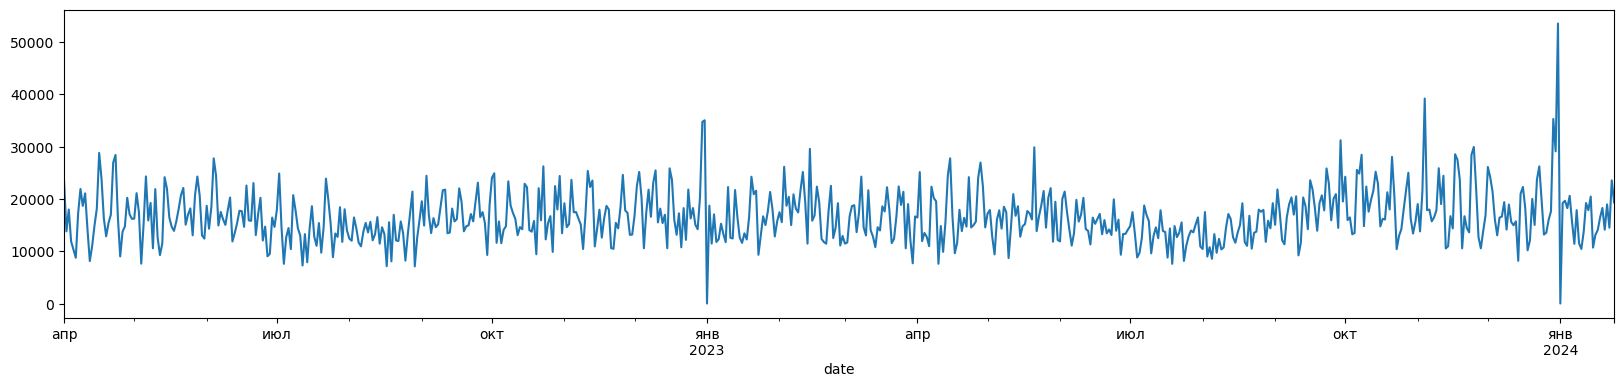

In [168]:
df.plot(figsize=(20,4))

1 января продажи отсутствуют (Действительно 1 января булочная закрыта)

<Axes: xlabel='date'>

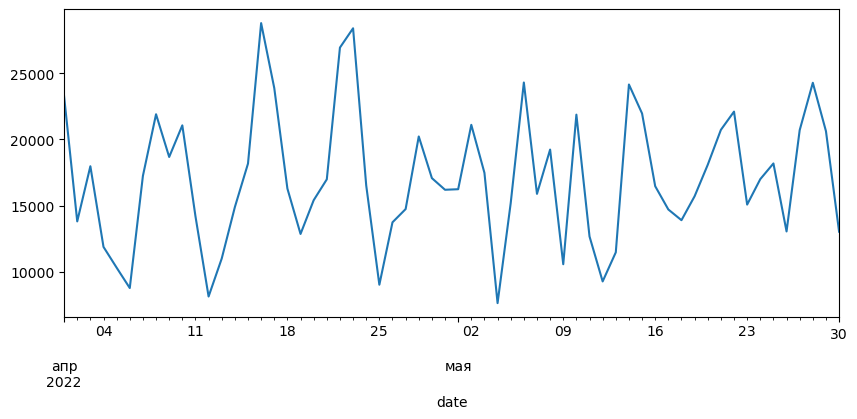

In [186]:
df.iloc[:60].plot(figsize=(10,4))

<Axes: xlabel='date'>

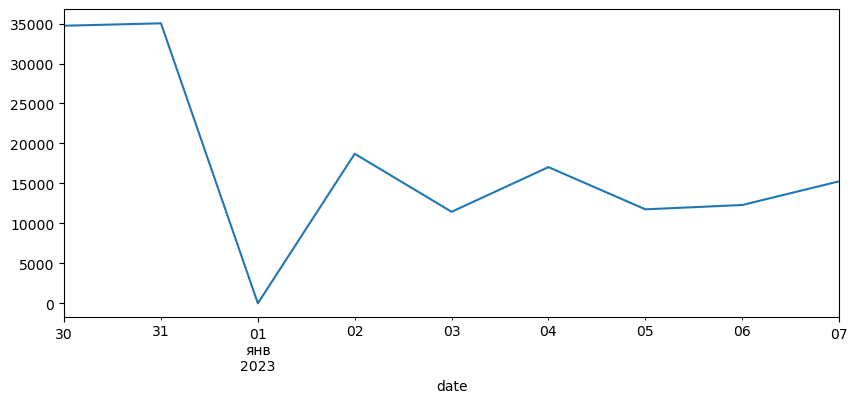

In [187]:
df.loc[pd.Timestamp('2022-12-30'):pd.Timestamp('2023-1-07')].plot(figsize=(10,4))


<Axes: xlabel='date'>

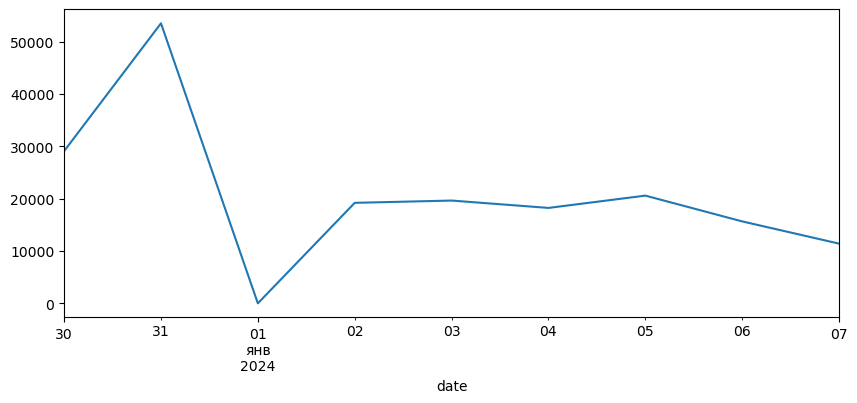

In [188]:
df.loc[pd.Timestamp('2023-12-30'):pd.Timestamp('2024-1-07')].plot(figsize=(10,4))

**Выводы по графическому предварительному анализу**

- Наблюдается выраженная годовая сезонность.
- Наблюдается недельная сезонность.
- Отсутствует выраженный тренд. Наличие невыраженного тренда требует исследования.
- 31 декабря наблюдается аномальное потребление круассанов
- 1 января кафе не работает или продаж нет.

** Проблемы **
- Объем имеющихся данных меньше двух лет, что затрудняет выявление годовой сезонности.

## Исследование временного ряда
### Анализ динамики временного ряда

Базисный темп роста

<Axes: xlabel='date'>

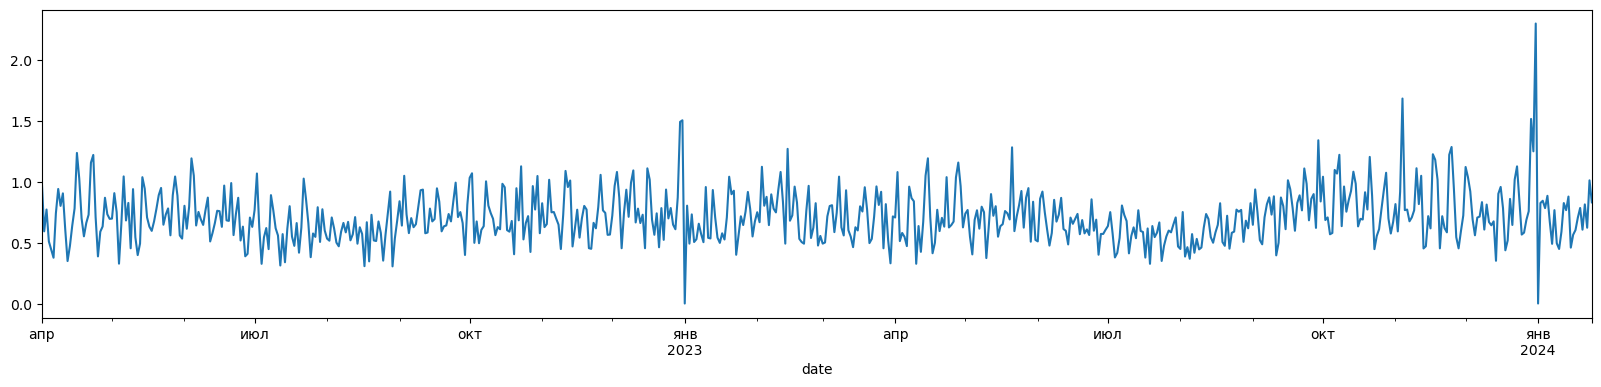

In [184]:
base_growth_rate = df/df['2022-04-01']
base_growth_rate.plot(figsize=(20,4))

<Axes: xlabel='date'>

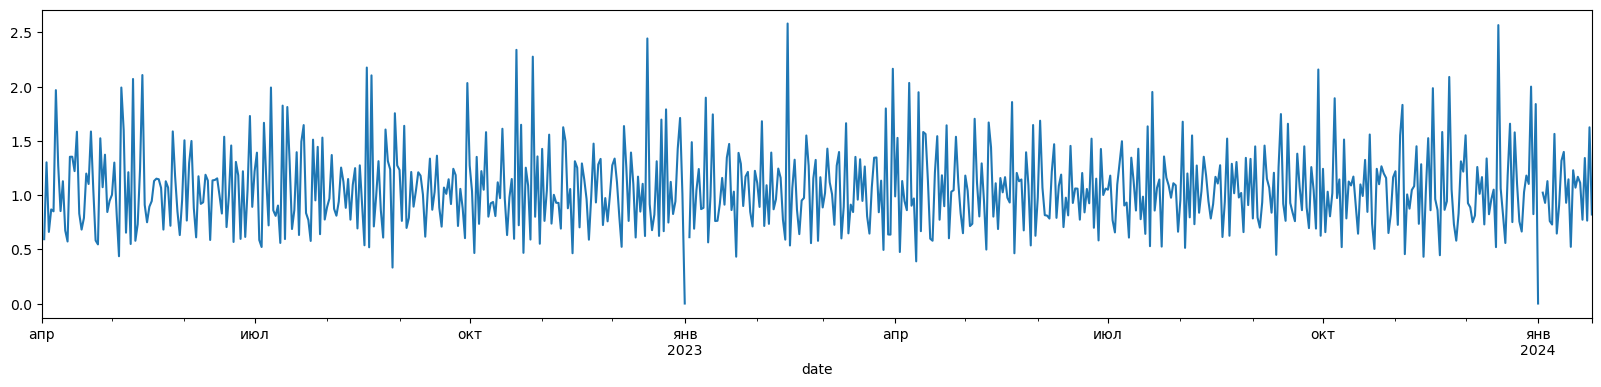

In [185]:
growth_rate = df/df.shift(1).dropna()
growth_rate.plot(figsize=(20,4))

Выводы:
- Визуально в темп роста не прослеживается сезонность и тренд

## Декомпозиция ряда

In [261]:
### Наивная декомпозиция

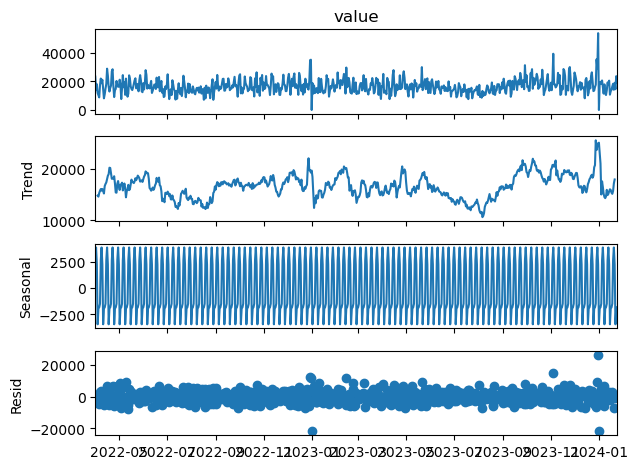

In [ ]:
sm.tsa.seasonal_decompose(df,).plot();

**Выводы**
1. Тренд вероятно отсутсвует или имеет место очень слабый тренд. Требуется исследование.
2. Сезонность по графику выявить затруднительно.  Требуется исследование

### Выявление тренда ряда
Реализуем метод разности средних

In [208]:
# Метод разности средних
split = df.shape[0]//2
df1 = df.iloc[:split]
df2 = df.iloc[split:]

In [209]:
print(f'Тест Шапиро-Уилка для ряда: {st.shapiro(df).pvalue:.6f}')
print(f'Тест Шапиро-Уилка для левой части: {st.shapiro(df1).pvalue:.6f}')
print(f'Тест Шапиро-Уилка для правой  части: {st.shapiro(df2).pvalue:.6f}')
print(f'Выборка нормально распределена')


Тест Шапиро-Уилка для ряда: 0.000000
Тест Шапиро-Уилка для левой части: 0.000039
Тест Шапиро-Уилка для правой  части: 0.000000
Выборка нормально распределена


In [257]:
# Проверим равенство дисперсий
# H0 - дисперси равны
# H1 - диспрсии не равны
n1= df1.shape[0]
n2= df2.shape[0]
D1 = np.var(df1,ddof=1)
D2 = np.var(df2,ddof=1)
F = D1/D2
p = 2*min(st.f.cdf(F, n2-1,n1-1), st.f.cdf(1/F, n2-1,n1-1))
p

np.float64(0.027560681703959766)

Дисперсии различны на уровне значимости 0.05, поэтому метод разности средних не применим.

Внимание!!! в лекции 3 была опечатка в формуле P-значения для F-критерия Фишера: должен быть минимум вместо максимума! В репозиторий исправления внес

Самостоятельно реализуйте метод Фостера—Стьюарта и установите, есть ли тренд в ряду (См. задание 1 в конце документа)

In [273]:
### Выявление сезонности ряда

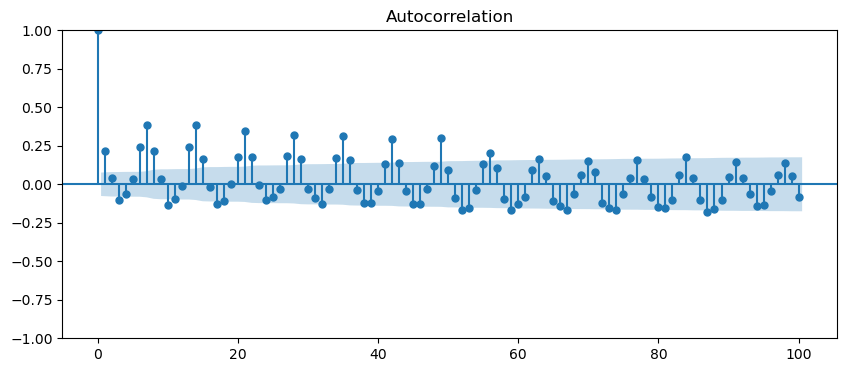

In [367]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df,ax=ax,lags=100)
plt.show();

Наблюдается значимая автокорреляция ряда лагом 7 (недельная сезонность)

In [360]:
freq = np.fft.rfftfreq(df.shape[0]) # вычисление частот 
periods = 1/freq
power_spec = np.abs(np.fft.rfft(df))**2

/tmp/ipykernel_299464/1913828877.py:2: RuntimeWarning: divide by zero encountered in divide
  periods = 1/freq


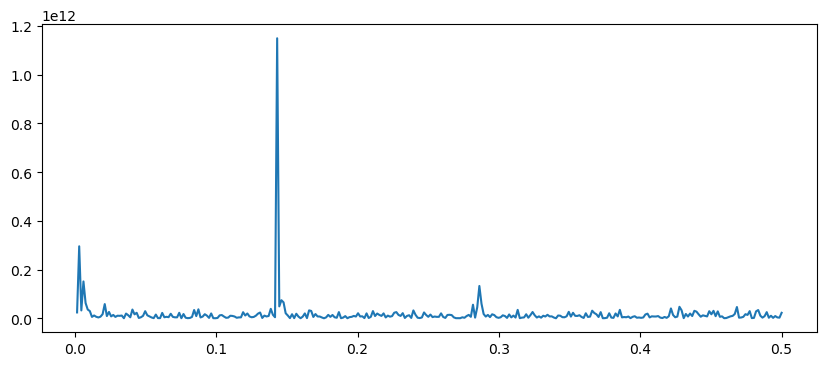

In [361]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freq[1:], power_spec[1:] )
plt.show()


In [320]:
idxmax = np.argmax(power_spec[1:]) # Максимум без нуля
max_freq = freq[idxmax+1]
period = 1/max_freq # период в днях
period

np.float64(6.989473684210526)

Имеет место ярко выраженный период в 7 дней.

Найдем другие периоды

In [364]:
df_spec = pd.DataFrame(data =np.hstack([periods.reshape(-1,1),power_spec.reshape(-1,1)]),columns = ['Период','Мощность']).iloc[1:,:].set_index('Период')
df_spec.sort_values('Мощность',ascending=False).head(5).round(3)

,Мощность
Период,
6.989474,1.149412e+12
332.000000,2.955741e+11
166.000000,1.512838e+11
3.494737,1.327033e+11
6.845361,7.421829e+10


Итак, 
- Наиболее выражена недельная сезонность
- Имеет место слабо выраженная годовая сезонность

## Погнозирование временного ряда

**Цель исследования:** спрогнозировать выручку на три дня вперед с наименьшей погрешностью.

### Формирование экспериментального стенда

Качество моделирования будем оценивать по величине средней абсолютной ошибки MAE. 

Для итоговой оценки качества модели выделим отложенную выборку - все дни 2024 года (`df_leave`).


Проверку и сравнение моделей будем выполнять c помощью кроссвалидации методом расширяющегося окна (Expanding Window Validation) реализованного 
в SciKit-Learn классом [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)

![Expanding Window Validation](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

При кроссвалидации требуется определить среднее значение величины MAE и ее стандартное отклонение.

In [194]:
df_leave = df.iloc[-24:] # Отложенная выборка
df = df.iloc[:-24] # Исследуемая выборка

In [195]:
tscv = TimeSeriesSplit(n_splits = 15, test_size = 3)
cv_data = [{
        'train': df.iloc[train_index], 
        'test': df.iloc[test_index]
} for train_index, test_index in tscv.split(df)]



In [196]:
def test_cv(pred_func, cv_data):
    '''
        Функция выполняет вычисление качества модели, заданной функцией прогнозирования pred_func
        на  кроссвалидационном наборе cv_data
    '''
    examples_mae = []
    for ex in cv_data:
        train = ex['train']
        test = ex['test']
        predict = pred_func(train, test)
        examples_mae.append(mean_absolute_error(test,predict))
    return examples_mae, np.mean(examples_mae), np.std(examples_mae)


* Список `cv_data` состоит из 15 элементов каждый из которых является словарем сродержащим две записи:
`train` - учебную выборку и `test` - тестовая выборка. Эти данные используются для сравнения модели.
* Кросс-валидационная выборка может быть пополнена.

* Выборка `df_leave` для итогового тестирования лучшей модели. 



### Эксперименты


#### A. Базовая модель
Спрогнозируем очередное значение средним выборочным по предыдущим четырем значениям того же дня недели, что и прогнозируемый.

In [197]:
def baseline_model(train, test):
    result = []
    for target_date in test.index:
        X = [-4,-3,-2,-1]
        Y = [train[target_date + pd.Timedelta(days=7*i)] for i in X]
        result.append(np.mean(Y))
    result = pd.Series(data = result,index = test.index)
    return result

In [198]:
MAEs, mean_mae, std_mae = test_cv(baseline_model, cv_data)

print(f'Среднее значение МАЕ для базовой модели: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для базовой модели: 3751.16 ± 4127.42


In [199]:
def naive_model(train, test):
    result = []
    for target_date in test.index:
        X = [-4,-3,-2,-1]
        Y = [train[target_date + pd.Timedelta(days=7*i)] for i in X]
        result.append(np.mean(Y))
    result = pd.Series(data = result,index = test.index)
    return result

In [200]:
MAEs, mean_mae, std_mae = test_cv(naive_model, cv_data)

print(f'Среднее значение МАЕ для базовой модели: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для базовой модели: 3751.16 ± 4127.42


#### Б. Модель прогнозирования экспоненциальным средним

In [176]:
m = SimpleExpSmoothing(df, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

### Б.1 Сглаживание

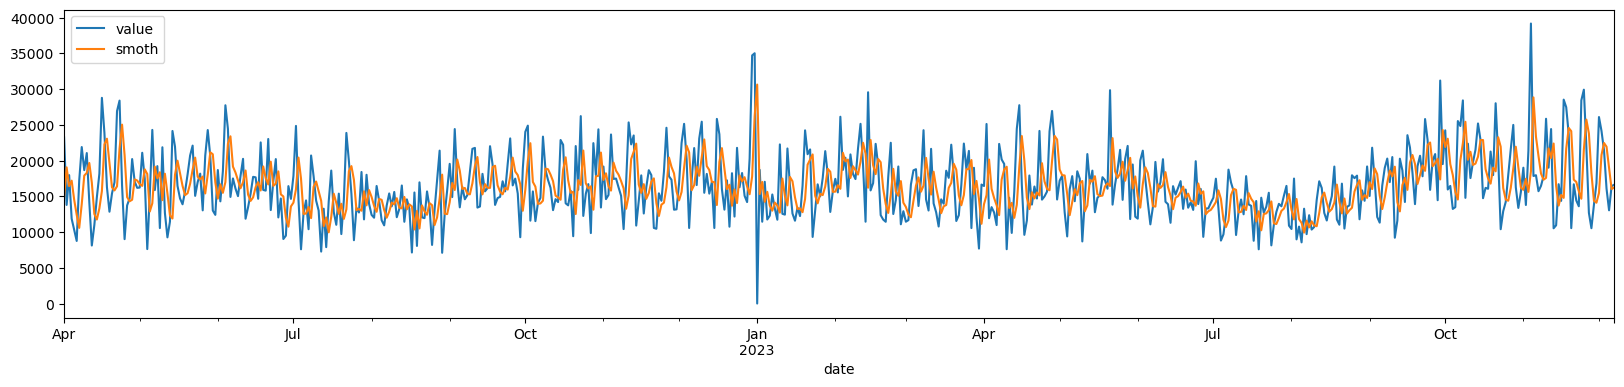

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
smoothed_df = m.fittedvalues
smoothed_df.name='smoth'
df.plot(ax = ax)
smoothed_df.plot(ax=ax)
ax.legend()
plt.show()

Наблюдаем уменьшение дисперсии. 
Вероятно, прогнозирование такой моделью будет давать существенную ошибку MAE.

### Б.2 Прогнозирование трех значений

In [167]:
def smoothed_model(train, test):
    return m.forecast(len(test))

In [168]:
MAEs, mean_mae, std_mae = test_cv(smoothed_model, cv_data)

print(f'Среднее значение МАЕ для модели на основе экспоненциального среднего: {mean_mae:.2f} ± {std_mae:.2f}')

Среднее значение МАЕ для модели на основе экспоненциального среднего: 4625.92 ± 2921.54


Как видим, модель хуже, чем базовая

## Задания на лабораторную работу




### Задание 1. Проверить наличие линейного тренда
* 1.1. Реализуйте метод Фостера—Стьюарта.
* 1.2. Установите наличие/отсутствие тренда в данных.
* 1.3. вычислите уравнение линейной регрессии для данных обучающей выборки и оцените значимость ее коэффициентов
* 1.4. Постройте линию тренда в одной системе координат с графиком. 
* 1.5. Сделайте вывод о наличии тренда.

### Задание 2. Модель экспоненциального сглаживания
* 2.1. Вручную реализовать модель экспоненциального сглаживания.
* 2.2. Продемонстрировать влияние выбора параметра экспоненциальной модели на сглаженнную кривую. При каких значениях параметров проявляется годовая сезонность?
* 2.3. Продемонстрировать влияние нулевого значения экспоненциального сглаживания. Взять в качестве нулевого значения экспоненциального сглаживания начальное значение и среднее первых 5 уровней временного ряда.
* 2.4. Реализовать прогнозирование одого дня с помощью модели экспоненциального сглаживания. Подобрать оптимальный параметр сглаживания путем минимизации MSE.
* 2.5. Выполнить экспоненциальное сглаживание с помощью функций Python с подбором оптимального параметра и начального значения. Сравнить параметры и результаты пунктов 2.5 и 2.4.



### Задание 3. Модель Хольта-Винтерса
3.1. Рассмотрем модели Хольта, Хольта-Винтерса в аддитивной, мультипликативной и смешанной формах с подбором параметров модели. Горизонт прогнозирования 3 дня.
3.2. Выполнить сравнение качества моделей на отложенной выборке.

### Задание 4. Предложить модель,  превосходящую по качеству базовую модель как можно сильнее.

Метрика качества MSE. 

Единственное ограничение модели - умение объяснять ее работу.